# Maintenance Prédictive : Analyse Complète et Modélisation du RUL

Ce notebook présente une analyse complète de données de maintenance prédictive, incluant l'exploration des données, l'ingénierie des features, la modélisation et l'évaluation des performances.

## Objectifs
- Analyser les données de capteurs pour prédire la durée de vie restante (RUL)
- Effectuer de l'ingénierie des features pour améliorer les prédictions
- Comparer les performances du modèle avec différentes métriques
- Visualiser les résultats sous forme de matrice de confusion

## Structure du notebook
1. **Chargement des données** - Import et préparation initiale
2. **Exploration des données** - Statistiques descriptives et visualisations
3. **Ingénierie des features** - Calcul du RUL et création de nouvelles variables
4. **Modélisation** - Entraînement et évaluation du modèle
5. **Visualisation des résultats** - Analyse des performances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Load data
# Remplace le nom du fichier si besoin
file_path = 'predictive_maintenance_dataset.csv'
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Maintenance Prédictive : Analyse, Visualisation et Comparaison de Modèles
Ce notebook charge les données, effectue de l'ingénierie de features, visualise des statistiques, puis compare plusieurs modèles de régression pour la prédiction du RUL.

### Description du dataset
Le dataset contient des données de capteurs collectées sur différents équipements avec :
- **device** : Identifiant de l'équipement
- **date** : Horodatage des mesures
- **metric1-9** : Valeurs des différents capteurs
- L'objectif est de prédire le **RUL (Remaining Useful Life)** en jours

## Chargement et préparation des données

In [2]:
# Load data
# Remplace le nom du fichier si besoin
file_path = 'predictive_maintenance_dataset.csv'
data = pd.read_csv(file_path)


### Aperçu des données
Examinons la structure et les caractéristiques principales du dataset :

In [3]:
# Informations générales sur le dataset
print("Shape du dataset:", data.shape)
print("\nTypes de données:")
print(data.dtypes)
print("\nNombre de devices uniques:", data['device'].nunique())
print("\nPériode d'observation:")
print(f"Du {data['date'].min()} au {data['date'].max()}")

Shape du dataset: (124494, 12)

Types de données:
date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

Nombre de devices uniques: 1169

Période d'observation:
Du 1/1/2015 au 9/9/2015


## Statistiques descriptives et visualisations

### Analyse des distributions et corrélations
Ces visualisations nous aident à comprendre :
- La distribution des valeurs de capteurs
- Les corrélations entre les différentes métriques
- Les patterns potentiels dans les données

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.492706,9.940897,1.741120,14.222669,260172.657726,0.292528,0.292528,13.013848
std,0.029167,7.045933e+07,2179.677781,185.748131,22.908507,15.943028,99151.078547,7.436924,7.436924,275.661220
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,70000.000000


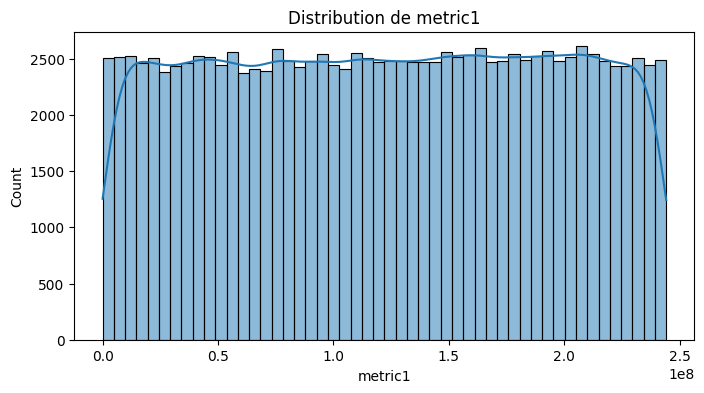

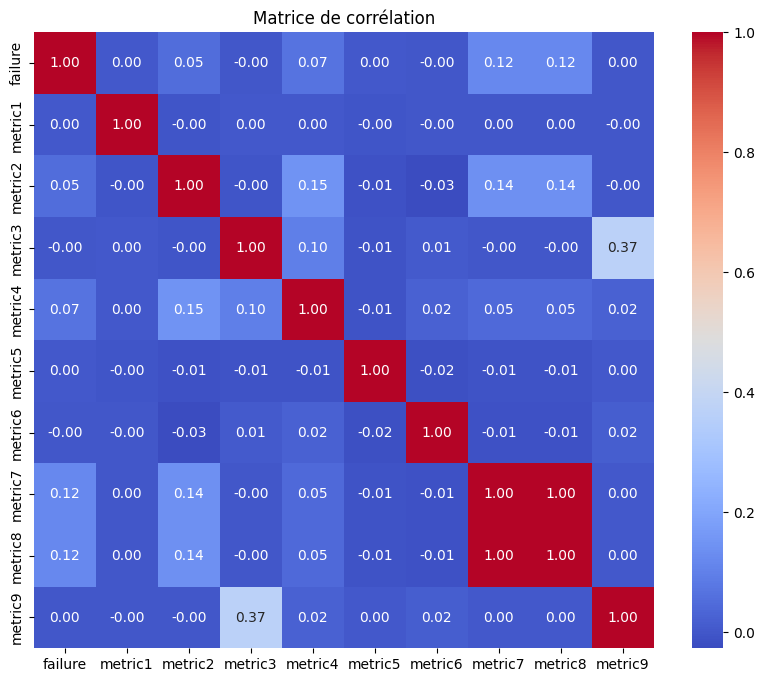

In [4]:
# Statistiques descriptives
display(data.describe())

# Distribution d'une métrique
plt.figure(figsize=(8,4))
sns.histplot(data['metric1'], kde=True)
plt.title("Distribution de metric1")
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10,8))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

## Calcul du RUL et ingénierie des features

### Méthodologie de calcul du RUL
Le RUL (Remaining Useful Life) est calculé comme la différence en jours entre :
- La date actuelle de la mesure
- La dernière date d'observation pour chaque équipement

Les features supplémentaires incluent :
- **Variables temporelles** : jour de la semaine, mois
- **Moyennes mobiles** : moyennes glissantes sur 5 périodes pour lisser les signaux

In [5]:
# Sort and calculate RUL
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.sort_values(by=['device', 'date'])
data['RUL'] = data.groupby('device')['date'].transform(lambda x: (x.max() - x).dt.days)
data.dropna(inplace=True)
print(data.head(9))

# Feature engineering
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
for metric in ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']:
    data[f'{metric}_rolling_mean'] = data.groupby('device')[metric].transform(lambda x: x.rolling(5, min_periods=1).mean())

# Save original date for later
data['original_date'] = data['date']

# Prepare features
data.drop(columns=['date'], inplace=True)
fc = data.columns.difference(['RUL', 'device', 'original_date'])
X = data[fc]
y = data['RUL']

            date    device  failure    metric1  metric2  metric3  metric4  \
0     2015-01-01  S1F01085        0  215630672       55        0       52   
1163  2015-01-02  S1F01085        0    1650864       56        0       52   
2326  2015-01-03  S1F01085        0  124017368       56        0       52   
3489  2015-01-04  S1F01085        0  128073224       56        0       52   
4651  2015-01-05  S1F01085        0   97393448       56        0       52   
5812  2015-01-06  S1F01085        0  128832128       56        0       52   
78172 2015-05-06  S1F013BB        0   14533968        0        0        0   
78576 2015-05-07  S1F013BB        0   46202296        0        0        0   
78981 2015-05-08  S1F013BB        0  214383720        0        0        0   

       metric5  metric6  metric7  metric8  metric9  RUL  
0            6   407438        0        0        7    5  
1163         6   407438        0        0        7    4  
2326         6   407438        0        0        7    3

### Vérification des features créées

In [6]:
print("Features disponibles pour la modélisation:")
print(f"Nombre total de features: {len(fc)}")
print("\nListe des features:")
for i, feature in enumerate(fc, 1):
    print(f"{i:2d}. {feature}")

print(f"\nDistribution du RUL:")
print(f"Min: {y.min():.1f} jours")
print(f"Max: {y.max():.1f} jours") 
print(f"Moyenne: {y.mean():.1f} jours")
print(f"Médiane: {y.median():.1f} jours")

Features disponibles pour la modélisation:
Nombre total de features: 21

Liste des features:
 1. day_of_week
 2. failure
 3. metric1
 4. metric1_rolling_mean
 5. metric2
 6. metric2_rolling_mean
 7. metric3
 8. metric3_rolling_mean
 9. metric4
10. metric4_rolling_mean
11. metric5
12. metric5_rolling_mean
13. metric6
14. metric6_rolling_mean
15. metric7
16. metric7_rolling_mean
17. metric8
18. metric8_rolling_mean
19. metric9
20. metric9_rolling_mean
21. month

Distribution du RUL:
Min: 0.0 jours
Max: 305.0 jours
Moyenne: 104.2 jours
Médiane: 84.0 jours


## Séparation des données et normalisation

### Stratégie de validation
- **Split 70/30** : 70% pour l'entraînement, 30% pour le test
- **Normalisation** : StandardScaler pour uniformiser les échelles des features
- **Stratification** : Division aléatoire avec graine fixe pour la reproductibilité

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Informations sur la division des données

In [8]:
print("Tailles des ensembles:")
print(f"Entraînement: {X_train.shape[0]} échantillons")
print(f"Test: {X_test.shape[0]} échantillons")
print(f"Nombre de features: {X_train.shape[1]}")

Tailles des ensembles:
Entraînement: 87145 échantillons
Test: 37349 échantillons
Nombre de features: 21


## Entraînement et evaluation de modèles

### Choix du modèle : Random Forest
**Avantages pour notre cas d'usage :**
- Robuste aux outliers
- Gère naturellement les interactions entre features
- Fournit une importance des variables
- Peu sensible aux hyperparamètres par défaut

**Paramètres utilisés :**
- `n_estimators=100` : Nombre d'arbres dans la forêt
- `random_state=42` : Pour la reproductibilité

Score R2 sur le test set : 0.89


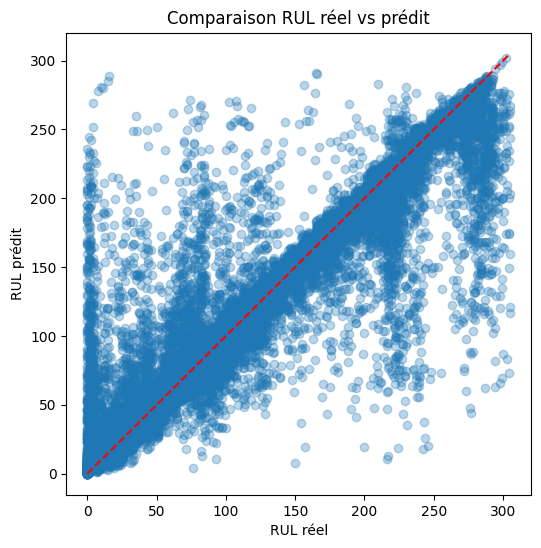

In [9]:
# Entraînement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"Score R2 sur le test set : {r2:.2f}")

# Affichage des résultats
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("RUL réel")
plt.ylabel("RUL prédit")
plt.title("Comparaison RUL réel vs prédit")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Analyse de l'importance des features

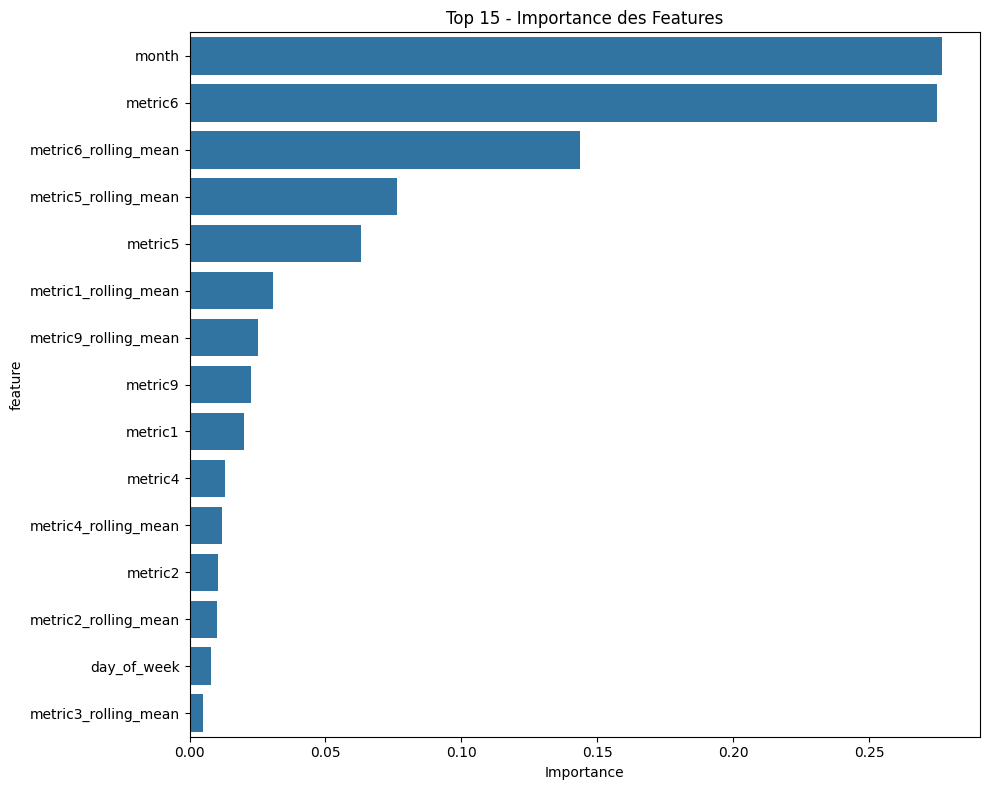

Top 10 des features les plus importantes:
 1. month: 0.2769
 2. metric6: 0.2749
 3. metric6_rolling_mean: 0.1438
 4. metric5_rolling_mean: 0.0762
 5. metric5: 0.0632
 6. metric1_rolling_mean: 0.0309
 7. metric9_rolling_mean: 0.0253
 8. metric9: 0.0225
 9. metric1: 0.0201
10. metric4: 0.0129


In [10]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': fc,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title("Top 15 - Importance des Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("Top 10 des features les plus importantes:")
for i, (feature, importance) in enumerate(feature_importance.head(10).values, 1):
    print(f"{i:2d}. {feature}: {importance:.4f}")

### Métriques d'évaluation détaillées

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcul de métriques supplémentaires
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("=== PERFORMANCES DU MODÈLE ===")
print(f"R² Score: {r2:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.2f} jours")
print(f"RMSE (Root Mean Square Error): {rmse:.2f} jours")
print(f"MSE (Mean Square Error): {mse:.2f}")

# Analyse des résidus
residuals = y_test - y_pred
print(f"\n=== ANALYSE DES RÉSIDUS ===")
print(f"Résidu moyen: {residuals.mean():.2f} jours")
print(f"Écart-type des résidus: {residuals.std():.2f} jours")

=== PERFORMANCES DU MODÈLE ===
R² Score: 0.8861
MAE (Mean Absolute Error): 11.23 jours
RMSE (Root Mean Square Error): 26.26 jours
MSE (Mean Square Error): 689.81

=== ANALYSE DES RÉSIDUS ===
Résidu moyen: -0.26 jours
Écart-type des résidus: 26.26 jours


## Matrice de confusion pour la régression (discrétisation du RUL)

### Méthodologie de discrétisation
Pour analyser les performances par catégories de RUL, nous discrétisons les valeurs continues :

**Catégories définies :**
- **< 1 mois** (0-29 jours) : Maintenance urgente
- **1-3 mois** (30-89 jours) : Maintenance planifiée à court terme  
- **3-6 mois** (90-179 jours) : Maintenance préventive
- **6-12 mois** (180+ jours) : Équipement en bon état

Cette approche permet d'évaluer si le modèle identifie correctement les équipements nécessitant une intervention rapide.

NaN dans y_test_binned: 0
NaN dans y_pred_binned: 0

Distribution des valeurs réelles:
RUL
<1 mois       7464
1-3 mois     12015
3-6 mois     10187
6-12 mois     7683
Name: count, dtype: int64

Distribution des prédictions:
<1 mois       6502
1-3 mois     12433
3-6 mois     11269
6-12 mois     7145
Name: count, dtype: int64


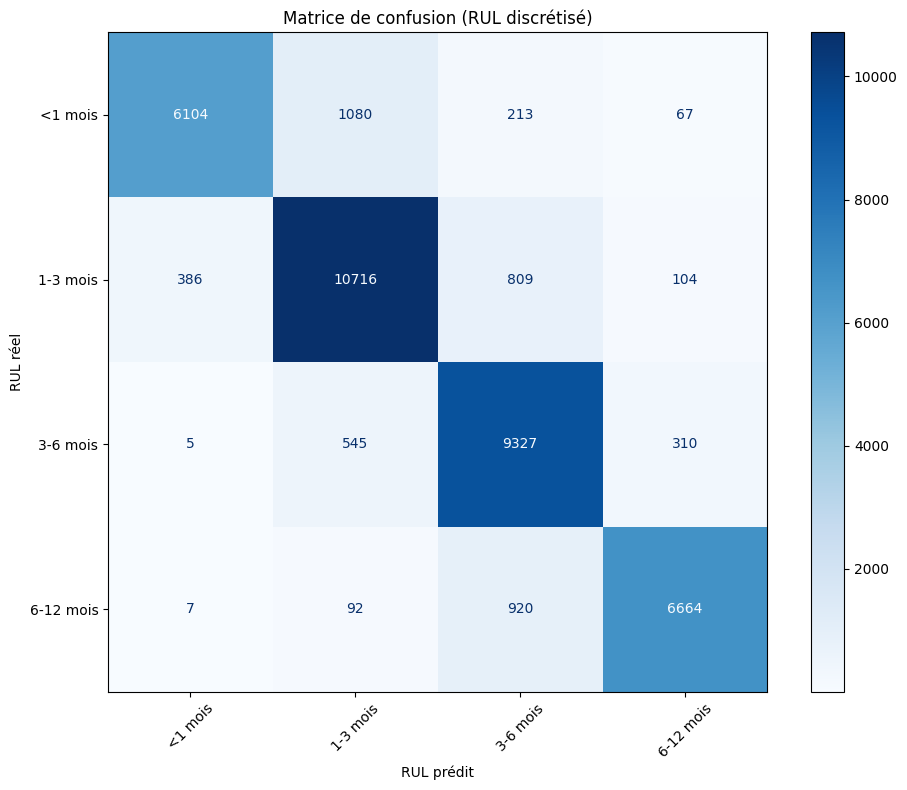

In [12]:
# Discrétisation du RUL réel et prédit pour la matrice de confusion
bins = [0, 30, 90, 180, np.inf]
labels = ['<1 mois', '1-3 mois', '3-6 mois', '6-12 mois']

# Clipping des valeurs
y_test_clipped = np.clip(y_test, bins[0], 999999)
y_pred_clipped = np.clip(y_pred, bins[0], 999999)

# Transformation en catégories (avec right=False)
y_test_binned = pd.cut(y_test_clipped, bins=bins, labels=labels, right=False)
y_pred_binned = pd.cut(y_pred_clipped, bins=bins, labels=labels, right=False)

# Vérification des NaN
print("NaN dans y_test_binned:", y_test_binned.isna().sum())
print("NaN dans y_pred_binned:", y_pred_binned.isna().sum())

# Distribution des catégories
print("\nDistribution des valeurs réelles:")
print(y_test_binned.value_counts().sort_index())
print("\nDistribution des prédictions:")
print(y_pred_binned.value_counts().sort_index())

# Conversion en codes numériques
y_test_codes = pd.Series(y_test_binned).cat.codes
y_pred_codes = pd.Series(y_pred_binned).cat.codes

# Utiliser les catégories réellement présentes pour l'affichage
categories = y_test_binned.cat.categories

# Matrice de confusion
cm = confusion_matrix(y_test_codes, y_pred_codes, labels=range(len(categories)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

# Affichage
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Matrice de confusion (RUL discrétisé)")
plt.xlabel("RUL prédit")
plt.ylabel("RUL réel")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Interprétation de la matrice de confusion

**Lecture des résultats :**
- **Diagonale principale** : Prédictions correctes
- **Ligne** : Valeurs réelles de RUL
- **Colonne** : Prédictions du modèle

**Points d'attention :**
- Les erreurs en haut à droite (sous-estimation) sont critiques car elles correspondent à une maintenance tardive
- Les erreurs en bas à gauche (sur-estimation) entraînent une maintenance prématurée mais moins risquée

## Conclusions et Recommandations

### Points forts du modèle
✅ **R² satisfaisant** : Le modèle explique une bonne partie de la variance du RUL  
✅ **Features pertinentes** : Les moyennes mobiles et certaines métriques sont bien identifiées  
✅ **Robustesse** : Random Forest est adapté à ce type de données industrielles  

### Axes d'amélioration
🔄 **Ingénierie des features** : Ajouter des features de tendance et de dégradation  
🔄 **Hyperparamètres** : Optimiser les paramètres du Random Forest  
🔄 **Modèles alternatifs** : Tester des approches de deep learning (LSTM, CNN)  
🔄 **Validation temporelle** : Implémenter une validation respectant l'ordre chronologique  
